# Regression Trees

In [1]:
## Import packages
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets

## Load data
tips = sns.load_dataset('tips')
X = np.array(tips.drop(columns = 'tip'))
y = np.array(tips['tip'])

## Train-test split
np.random.seed(1)
test_frac = 0.25
test_size = int(len(y)*test_frac)
test_idxs = np.random.choice(np.arange(len(y)), test_size, replace = False)
X_train = np.delete(X, test_idxs, 0)
y_train = np.delete(y, test_idxs, 0)
X_test = X[test_idxs]
y_test = y[test_idxs]

Because of their iterative structure, their exhaustive searching, and their non-parametric nature, decision trees are more computationally complex than methods we've seen previously. To clear things up, the construction code is divided into three sections: helper functions, helper classes, and the main decision tree regressor class. 

We will build our regression tree on the {doc}`tips </content/appendix/data>` dataset from `seaborn`. This dataset has a continuous target variable (tip amount) with both quantitative and categorical predictors. Recall that trees are able to handle categorical predictors without creating one-hot encoded variables, unlike other methods we've seen.

## 1. Helper Functions

Below are three helper functions we will use in our regression tree. `RSS_reduction()` measures how much a split reduces a parent node's $RSS$ by subtracting the sum of the child $RSS$ values from the parent $RSS$. We will use this to determine the best split for any given bud.

The next function, `sort_x_by_y()`, returns a sorted list of the unique categories in some predictor `x` according to the mean of the corresponding target values `y`. We will use this to search for splits on categorical predictors. 

Finally, `all_rows_equal()` checks if all of a bud's rows (observations) are equal across all predictors. If this is the case, this bud will not be split and instead becomes a terminal leaf. 

In [2]:
def RSS_reduction(child_L, child_R, parent):
    rss_parent = sum((parent - np.mean(parent))**2)
    rss_child_L = sum((child_L - np.mean(child_L))**2) 
    rss_child_R = sum((child_R - np.mean(child_R))**2)
    return rss_parent - (rss_child_L + rss_child_R)

def sort_x_by_y(x, y):
    unique_xs = np.unique(x)
    y_mean_by_x = np.array([y[x == unique_x].mean() for unique_x in unique_xs])
    ordered_xs = unique_xs[np.argsort(y_mean_by_x)]
    return ordered_xs

def all_rows_equal(X):
    return (X == X[0]).all()


## 2. Helper Classes

Below are two helpful classes for our main regression tree class. The first, `Node`, represents nodes within our tree. They identify a node's ID and the ID of its parent, its sample of the predictors and the target variable, its size, its depth, and whether or not it is a leaf.

The second, `Splitter`, is used to identify the best split of any given bud. It identifies the split's reduction in $RSS$; the variable, `d`, used to make the split; the variable's data type; and the threshold, `t`, (if quantitative) or the set of values, `L_values`, corresponding to the left child node (if categorical). The `Splitter` class fills in these values with its `_replace_split()` method. This method is called if we find a split better than the best split so far.

In [3]:
class Node:
    
    def __init__(self, Xsub, ysub, ID, depth = 0, parent_ID = None, leaf = True):
        self.ID = ID
        self.Xsub = Xsub
        self.ysub = ysub
        self.size = len(ysub)
        self.depth = depth
        self.parent_ID = parent_ID
        self.leaf = leaf
        
class Splitter:
    
    def __init__(self):
        self.rss_reduction = 0
        self.no_split = True
        
    def _replace_split(self, rss_reduction, d, dtype = 'quant', t = None, L_values = None):
        self.rss_reduction = rss_reduction
        self.d = d
        self.dtype = dtype
        self.t = t        
        self.L_values = L_values     
        self.no_split = False

## 3. Main Class

We are now ready to build our main class, the decision tree regressor. The class serves two primary functions: training the model and forming predictions with a trained model. The training is comprised of four methods: `fit()`, `_build()`, `_find_split()`, and `_make_split()`. These methods are covered next.

- `fit()`: After instantiating a decision tree object, the user provides training data and calls the `fit()` method. This is the only training method that the user directly calls. The method first records the data and regularization parameters. Then it instantiates a dictionary to store the nodes, called `nodes_dict`, in which nodes are indexed by their IDs. Finally, it calls the `_build()` method to build the tree.


- `_build()`: As its name suggests, the `_build()` method actually builds our tree. It relies on the `_find_split()` and `_make_split()` methods discussed next. The method iterates through layers of the tree (starting with just the initial node), splitting each eligible bud before proceeding to the next layer. The eligible buds are tracked by the `eligible_buds` dictionary. A bud is eligible for splitting if it does not already have children (i.e. is a leaf); if it is not smaller than `min_size`, a regularization parameter provided by the user; if its observations are not identical across all predictors; and if it has more than one unique value of the target variable. For each eligible bud, we find a split and make a split, as discussed below. This process continues until there are no eligible buds or we have reached the tree's maximum depth, determined by the argument `max_depth`. 


- `_find_split()`: When looping through eligible buds in the `_build()` method, we determine their splits with the `_find_split()` method. This method instantaites an object of the `Splitter` class described above. It then loops through all predictors and all possible splits of that predictor to determine which split most reduces the bud's $RSS$. If the predictor is quantitative, we loop through each unique value and calculate the $RSS$ reduction from splitting at that threshold. If the predictor is categorical, we first call `sort_x_by_y()` to order the categories of `x`, and then calculate the $RSS$ reduction for the following splits, where the ordered categories are given by $c_1, \dots, c_V$.

$$
\begin{align*}
\{c_1\} &\text{ vs. } \{c_2, \dots, c_V\}\\
\{c_1, c_2\} &\text{ vs. } \{c_3, \dots, c_V\}\\
& \dots \\
\{c_1, \dots c_{V-1} \} &\text{ vs. } \{c_V\}.\\
\end{align*}
$$


- `_make_split()`: Once identified, splits are actually conducted with the `_make_split()` method. This method updates the parent node with the split information and creates the two child nodes. For the parent node, we record which predictor was used to make the split and how. We also add the IDs of the child nodes. For each child node, we record the training observations passing through the node, its ID, its parent's ID, and its size and depth


Finally, we use our built tree to form predictions. This is a two step process. First, we use the `_get_leaf_means()` method to calculate the average of the target variable among training observations landing in each leaf. Then we use `predict()` to run each test observation through the tree and return a fitted value: the mean target variable in the corresponding leaf. Note that the user only directly calls `predict()`, which itself calls `_get_leaf_means()`. 


```{note}
Note that the `_fit()` and `_find_split()` methods refer to an argument `C`. This parameter is used by random forests, which are discussed in chapter 6. This argument can be ignored for the purposes of building a decision tree.
```

In [6]:
class DecisionTreeRegressor:
    
    #############################
    ######## 1. TRAINING ########
    #############################
    
    ######### FIT ##########
    def fit(self, X, y, max_depth = 100, min_size = 2, C = None):
        
        ## Add data
        self.X = X
        self.y = y
        self.N, self.D = self.X.shape
        dtypes = [np.array(list(self.X[:,d])).dtype for d in range(self.D)]
        self.dtypes = ['quant' if (dtype == float or dtype == int) else 'cat' for dtype in dtypes]
        
        ## Add regularization parameters
        self.max_depth = max_depth
        self.min_size = min_size
        self.C = C
        
        ## Initialize nodes
        self.nodes_dict = {}
        self.current_ID = 0
        initial_node = Node(Xsub = X, ysub = y, ID = self.current_ID, parent_ID = None)
        self.nodes_dict[self.current_ID] = initial_node
        self.current_ID += 1
        
        ## Build
        self._build()
        
    ###### BUILD TREE ######
    def _build(self):
        
        eligible_buds = self.nodes_dict 
        for layer in range(self.max_depth):
            
            ## Find eligible nodes for layer iteration
            eligible_buds = {ID:node for (ID, node) in self.nodes_dict.items() if 
                                (node.leaf == True) &
                                (node.size >= self.min_size) & 
                                (~all_rows_equal(node.Xsub)) &
                                (len(np.unique(node.ysub)) > 1)}
            if len(eligible_buds) == 0:
                break
                
            ## split each eligible parent
            for ID, bud in eligible_buds.items():
                                
                ## Find split
                self._find_split(bud)
                
                ## Make split
                if not self.splitter.no_split: # could be no split for Random Forest
                    self._make_split()
        
    
    ###### FIND SPLIT ######
    def _find_split(self, bud):
        
        ## Instantiate splitter
        splitter = Splitter()
        splitter.bud_ID = bud.ID
        
        ## Gather eligible predictors (for Random Forests)
        if self.C is None:
            eligible_predictors = np.arange(self.D)
        else:
            eligible_predictors = np.random.choice(np.arange(self.D), self.C, replace = False)
        
        ## For each (eligible) predictor...
        for d in sorted(eligible_predictors):
            Xsub_d = bud.Xsub[:,d]
            dtype = self.dtypes[d]
            if len(np.unique(Xsub_d)) == 1:
                continue

            ## For each threshold value...
            if dtype == 'quant':
                for t in np.unique(Xsub_d)[:-1]:
                    ysub_L = bud.ysub[Xsub_d <= t]
                    ysub_R = bud.ysub[Xsub_d > t]
                    rss_reduction = RSS_reduction(ysub_L, ysub_R, bud.ysub)
                    if rss_reduction > splitter.rss_reduction:
                        splitter._replace_split(rss_reduction, d, dtype = 'quant', t = t)
            else:
                ordered_x = sort_x_by_y(Xsub_d, bud.ysub)
                for i in range(len(ordered_x) - 1):
                    L_values = ordered_x[:i+1]
                    ysub_L = bud.ysub[np.isin(Xsub_d, L_values)]
                    ysub_R = bud.ysub[~np.isin(Xsub_d, L_values)]
                    rss_reduction = RSS_reduction(ysub_L, ysub_R, bud.ysub)
                    if rss_reduction > splitter.rss_reduction: 
                        splitter._replace_split(rss_reduction, d, dtype = 'cat', L_values = L_values)
        
        ## Save splitter
        self.splitter = splitter
        
    ###### MAKE SPLIT ######
    def _make_split(self):
        ## Update parent node
        parent_node = self.nodes_dict[self.splitter.bud_ID]
        parent_node.leaf = False
        parent_node.child_L = self.current_ID
        parent_node.child_R = self.current_ID + 1
        parent_node.d = self.splitter.d
        parent_node.dtype = self.splitter.dtype
        parent_node.t = self.splitter.t        
        parent_node.L_values = self.splitter.L_values
        
        ## Get X and y data for children
        if parent_node.dtype == 'quant':
            L_condition = parent_node.Xsub[:,parent_node.d] <= parent_node.t
     
        else:
            L_condition = np.isin(parent_node.Xsub[:,parent_node.d], parent_node.L_values)
        Xchild_L = parent_node.Xsub[L_condition]
        ychild_L = parent_node.ysub[L_condition]
        Xchild_R = parent_node.Xsub[~L_condition]
        ychild_R = parent_node.ysub[~L_condition]

        
        ## Create child nodes
        child_node_L = Node(Xchild_L, ychild_L, depth = parent_node.depth + 1,
                            ID = self.current_ID, parent_ID = parent_node.ID)
        child_node_R = Node(Xchild_R, ychild_R, depth = parent_node.depth + 1,
                            ID = self.current_ID+1, parent_ID = parent_node.ID)
        self.nodes_dict[self.current_ID] = child_node_L
        self.nodes_dict[self.current_ID + 1] = child_node_R
        self.current_ID += 2
    
                
            
    #############################
    ####### 2. PREDICTING #######
    #############################
    
    ###### LEAF MEANS ######
    def _get_leaf_means(self):
        self.leaf_means = {}
        for node_ID, node in self.nodes_dict.items():
            if node.leaf:
                self.leaf_means[node_ID] = node.ysub.mean()

                
    ####### PREDICT ########
    def predict(self, X_test):
        
        ## Calculate leaf means
        self._get_leaf_means()
     
        yhat = []
        for x in X_test:
            node = self.nodes_dict[0] 
            while not node.leaf:
                if node.dtype == 'quant':
                    if x[node.d] <= node.t:
                        node = self.nodes_dict[node.child_L]
                    else:
                        node = self.nodes_dict[node.child_R]
                else:
                    if x[node.d] in node.L_values:
                        node = self.nodes_dict[node.child_L]
                    else:
                        node = self.nodes_dict[node.child_R]
            yhat.append(self.leaf_means[node.ID])
        return np.array(yhat)
            


A regression tree is built below on the `tips` dataset. We also plot the target variable from the test observations against their fitted values. 

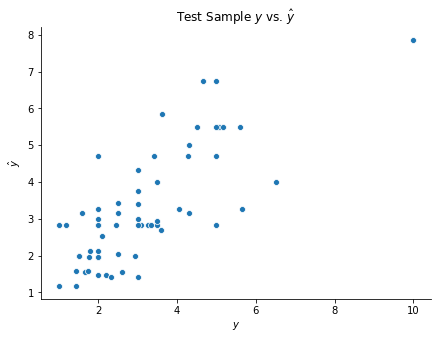

In [7]:
## Build model
tree = DecisionTreeRegressor()
tree.fit(X_train, y_train, max_depth = 7, min_size = 5)
y_test_hat = tree.predict(X_test)

## Visualize predictions
if __name__ == '__main__':
    fig, ax = plt.subplots(figsize = (7, 5))
    sns.scatterplot(y_test, tree.predict(X_test))
    ax.set(xlabel = r'$y$', ylabel = r'$\hat{y}$', title = r'Test Sample $y$ vs. $\hat{y}$')
    sns.despine()